## This notebook demos how to apply RQR-W objective on an example dataset

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TPouplin/RQR/blob/main/quick_start1.ipynb)

In [2]:
import torch 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch import nn
import matplotlib.pyplot as plt


## Set up within a self-contained notebook

In [3]:
# a simple MLP
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout
        bias = True
        self.base_model = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size, bias=bias),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.hidden_size, bias=bias),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.output_size, bias=bias),
        )
        for m in self.base_model:
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.base_model(x)
        return x

In [4]:
def GetDataset(name, base_path):
    data = np.loadtxt(base_path + f"/{name}.txt")
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    return X, y

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X, y = GetDataset("kin8nm", "data")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train)
X_train = scalerX.transform(X_train)
X_val = scalerX.transform(X_val)
X_test = scalerX.transform(X_test)

# scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train))
y_train = y_train / mean_ytrain
y_val = y_val / mean_ytrain
y_test = y_test / mean_ytrain

train_dataset = Dataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = Dataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = Dataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

BATCHSIZE = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

In [5]:
class RQRW(torch.nn.Module):
    """
    RQR-W loss function for quantile regression.
    
    Args:
        alpha: float, default=0.9
            The desired coverage level in (0,1).
        lam: float, default=0.
            Width minimizing regularization parameter >= 0.
    
    See also:
        "Relaxed Quantile Regression: Prediction Intervals for Asymmetric Noise"
    """
    def __init__(self, alpha: float = 0.9, lam: float = 0.):
        super().__init__()
        self.alpha = alpha
        self.l = lam
        self.q1 = (1 - lam)/2
        self.q2 = 1 - (1 - lam)/2
 
    def forward(self, preds: torch.Tensor,  target: torch.Tensor) -> torch.Tensor:
        y_pred_q1 = preds[:, 0]
        y_pred_q2 = preds[:, 1]

        diff_mu_1 = target - y_pred_q1 
        diff_mu_2 = target - y_pred_q2
        width = y_pred_q2 - y_pred_q1 
        RQR_loss = torch.maximum(diff_mu_1 * diff_mu_2 * (self.alpha + 2 * self.l),
                                 diff_mu_2 * diff_mu_1 * (self.alpha + 2 * self.l - 1))
        penalty = self.l * torch.square(width) * 0.5
        loss = RQR_loss + penalty

        return torch.mean(loss)

### Now lets train an MLP with RQR-W loss on this data

In [6]:
# train the mlp on this data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[1]

penalty = 1
learning_rate = 1e-3 
num_epochs = 400
dropout = 0.1

def train_model(penalty, learning_rate):
    coverage = 0.8
    hidden_size = 64
    output_size = 2
    model = MLP(input_size, hidden_size, output_size, dropout).to(device)
    criterion = RQRW(coverage, penalty)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y[:,0])
            loss.backward()
            optimizer.step()
        
        
    # extract the predictions on the train set
    model.eval()
    train_preds = []
    train_targets = []
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        outputs = model(X)
        train_preds.append(outputs.cpu().detach().numpy())
        train_targets.append(y.cpu().detach().numpy())
    return train_preds, train_targets

In [7]:
train_preds, train_targets = train_model(penalty=penalty, learning_rate=learning_rate)

## and plot results

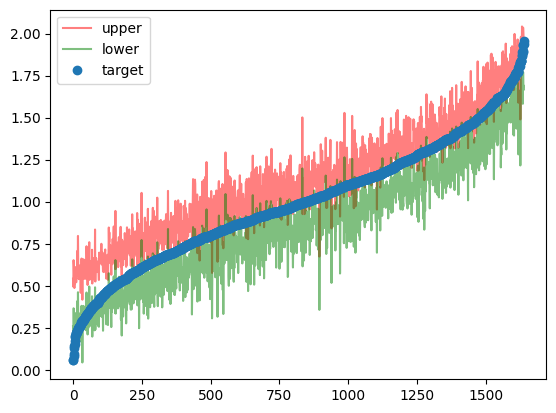

In [8]:
def plot_results(train_preds, train_targets):
    train_preds = np.concatenate(train_preds)
    uppers = train_preds.max(1)
    lowers = train_preds.min(1)

    # sort the train targets and use the same sorting on uppers and lowers
    train_targets = np.concatenate(train_targets).flatten()
    idx = np.argsort(train_targets)
    train_targets = train_targets[idx]
    uppers = uppers[idx]
    lowers = lowers[idx]
    plt.plot(list(range(len(uppers))), uppers, '-', color='red', alpha=0.5, label='upper')
    plt.plot(list(range(len(uppers))), lowers, '-', color='green', alpha=0.5, label='lower')
    plt.plot(list(range(len(uppers))), train_targets, 'o', label='target')
    plt.legend()
    plt.show()

plot_results(train_preds, train_targets)